<a href="https://colab.research.google.com/github/denisangelo/Federated_Learning/blob/main/ExemploCryptenRegressaoLogistica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Importa Pytorch,crypten
!pip install crypten
!pip install torch
!pip install torchvision
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#Importa as bibliotecas necessárias
import matplotlib.pyplot as plt
import numpy as np
import crypten
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid
from torchvision.datasets import CIFAR10

In [4]:
crypten.init()
torch.set_num_threads(1)

In [5]:
#Carrega os dados CIFAR10

#transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize( (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform = transforms.Compose([transforms.RandomHorizontalFlip(),transforms.ToTensor(),])
trainset = CIFAR10(root="./data", train=True,download=True, transform=transform)
testset = CIFAR10(root="./data", train=False, download=True, transform=transform)
#labels
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:04<00:00, 40879396.65it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
print('Tamanho do conjunto de treino:', len((trainset)))
print('Tamanho do conjunto de teste:', len((testset)))

Tamanho do conjunto de treino: 50000
Tamanho do conjunto de teste: 10000


Esta imagem é um: cat


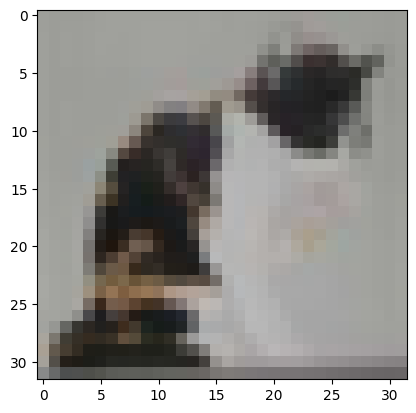

In [8]:
example = 785

image, label = trainset[example]

print("Esta imagem é um: " + classes[(trainset[example])[1]])
plt.imshow(image.permute(1,2,0))




In [9]:
train_dl = DataLoader(trainset, batch_size=64,shuffle=True)
test_dl= DataLoader(testset, batch_size=64)

In [10]:
print('Tamanho do conjunto de treino:', len((train_dl)))
print('Tamanho do conjunto de teste:', len((test_dl)))

Tamanho do conjunto de treino: 782
Tamanho do conjunto de teste: 157


In [11]:
def show_batch(dl):
 for image, label in dl:
  fig,ax = plt.subplots(figsize =(10,5))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(image,nrow=16).permute(1,2,0))
  break


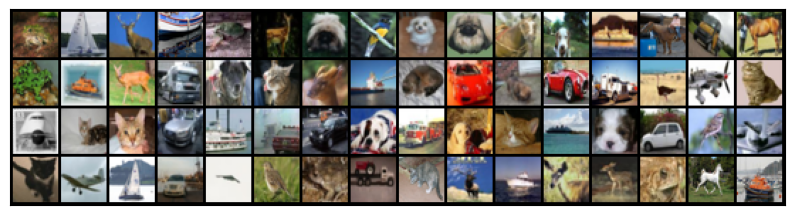

In [12]:
show_batch(train_dl)

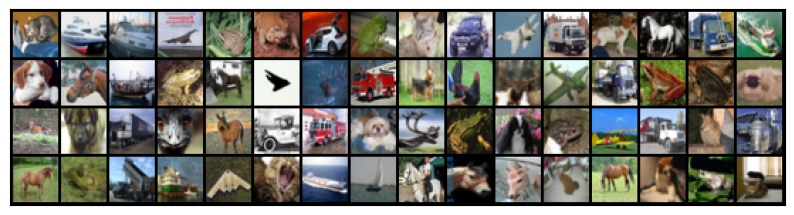

In [13]:
show_batch(test_dl)

In [14]:
#Pré processamento entre tensores
def take_samples(trainset, n_samples=5000):
  #Retorna images e labels em conjunto de amostras
  images,labels =[],[]
  for i,trainset in enumerate(trainset):
    if i==n_samples:
      break
    image, label = trainset
    images.append(image)
    label_one_hot = torch.nn.functional.one_hot(torch.tensor(label),10)
    labels.append(label_one_hot)

  images = torch.cat(images)
  labels = torch.stack(labels)
  return images,labels

In [17]:
images,labels = take_samples(trainset, n_samples=5000)

In [18]:
print(images.shape)
print(labels.shape)

torch.Size([15000, 32, 32])
torch.Size([5000, 10])


In [19]:
images_enc = crypten.cryptensor(images)
labels_enc = crypten.cryptensor(labels)

In [20]:
images_enc[3]

MPCTensor(
	_tensor=tensor([[39578, 32382, 26985,  ..., 23387, 22359, 20303],
        [35980, 37265, 32125,  ..., 24672, 19789, 18247],
        [35980, 35723, 29555,  ..., 20303, 17476, 17219],
        ...,
        [44975, 40092, 39578,  ..., 10794, 15677, 23901],
        [42405, 40092, 40863,  ..., 26471, 31611, 33667],
        [41891, 40606, 41891,  ..., 36751, 36751, 36751]])
	plain_text=HIDDEN
	ptype=ptype.arithmetic
)

In [21]:
images_enc[3].unsqueeze(0)

MPCTensor(
	_tensor=tensor([[[39578, 32382, 26985,  ..., 23387, 22359, 20303],
         [35980, 37265, 32125,  ..., 24672, 19789, 18247],
         [35980, 35723, 29555,  ..., 20303, 17476, 17219],
         ...,
         [44975, 40092, 39578,  ..., 10794, 15677, 23901],
         [42405, 40092, 40863,  ..., 26471, 31611, 33667],
         [41891, 40606, 41891,  ..., 36751, 36751, 36751]]])
	plain_text=HIDDEN
	ptype=ptype.arithmetic
)

In [22]:
x=images_enc[3].unsqueeze(0)
print(x.shape)


torch.Size([1, 32, 32])


In [23]:
#Conjunto de imagens de teste
images_test,labels_test = take_samples(testset, n_samples=1000)
images_test_enc = crypten.cryptensor(images_test)
labels_test_enc = crypten.cryptensor(labels_test)

In [24]:
#Modelo de regressão Logística
class LogisticRegression(crypten.nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = crypten.nn.Linear(3*32*32,10)
  def forward(self,x):
    x=x.reshape(-1,3072)
    out =self.linear(x)
    return out

In [25]:
model = LogisticRegression().encrypt()

In [ ]:
model.linear

Linear encrypted module

In [26]:
model(images_enc)

MPCTensor(
	_tensor=tensor([[  8479,    822,  -4828,  ...,    -54,  -1709, -15778],
        [ -3782,  -3890, -27283,  ...,   2780,   2905, -41255],
        [ -3637, -13594, -16451,  ...,   6100, -14949, -47561],
        ...,
        [ -4282,  -4194, -11339,  ...,  12172,   -578, -21988],
        [ 14617,  -2298, -12507,  ...,   8348,   4832, -37984],
        [ 25784,  -3802,  -9400,  ...,  12303,   3761, -19299]])
	plain_text=HIDDEN
	ptype=ptype.arithmetic
)

In [49]:
#Modelo de Treinamento em imagens criptografadas
def train_model(model, X, y, epochs=1000, learning_rate=0.001):
    criterion = crypten.nn.CrossEntropyLoss()
    for epoch in range(epochs):
        model.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        print(f"epoch {epoch} loss: {loss.get_plain_text()}")
        loss.backward()
        model.update_parameters(learning_rate)
    return model

In [50]:
model = train_model(model, images_enc, labels_enc)

epoch 0 loss: 2.3291168212890625
epoch 1 loss: 2.3277130126953125
epoch 2 loss: 2.326385498046875
epoch 3 loss: 2.3252105712890625
epoch 4 loss: 2.3240509033203125
epoch 5 loss: 2.322967529296875
epoch 6 loss: 2.3219146728515625
epoch 7 loss: 2.3209991455078125
epoch 8 loss: 2.3199920654296875
epoch 9 loss: 2.319061279296875
epoch 10 loss: 2.318145751953125
epoch 11 loss: 2.3172607421875
epoch 12 loss: 2.316436767578125
epoch 13 loss: 2.3155670166015625
epoch 14 loss: 2.314727783203125
epoch 15 loss: 2.31390380859375
epoch 16 loss: 2.3130950927734375
epoch 17 loss: 2.3123321533203125
epoch 18 loss: 2.3115386962890625
epoch 19 loss: 2.310791015625
epoch 20 loss: 2.31005859375
epoch 21 loss: 2.3093414306640625
epoch 22 loss: 2.3086090087890625
epoch 23 loss: 2.3079986572265625
epoch 24 loss: 2.3072509765625
epoch 25 loss: 2.306610107421875
epoch 26 loss: 2.305938720703125
epoch 27 loss: 2.305328369140625
epoch 28 loss: 2.3046722412109375
epoch 29 loss: 2.304046630859375
epoch 30 loss: 2.

In [51]:
x=images_enc[0].unsqueeze(0)
print(x.shape)
u=x.reshape
print(u)


torch.Size([1, 32, 32])
<function CrypTensor._get_autograd_forward_function.<locals>.autograd_forward at 0x7f079a16c790>


In [52]:
prediction = model(images_enc)


In [53]:
print(prediction.get_plain_text())

tensor([[ 3.6185,  5.8402,  5.5442,  ...,  5.6686,  3.7193,  4.5174],
        [ 6.4125,  7.2764,  6.6255,  ...,  6.4324,  7.5684,  6.1605],
        [ 8.8545,  8.3482,  7.8534,  ...,  7.7911,  9.2871, 10.5305],
        ...,
        [ 6.1741,  7.1443,  6.7274,  ...,  6.8244,  6.6092,  7.8171],
        [ 7.4459,  8.1149,  9.4113,  ...,  8.4564,  7.1364,  7.9109],
        [ 3.3391,  3.7260,  4.2745,  ...,  4.2411,  2.8991,  2.8701]])


In [54]:
prediction.get_plain_text().argmax()

tensor(46010)

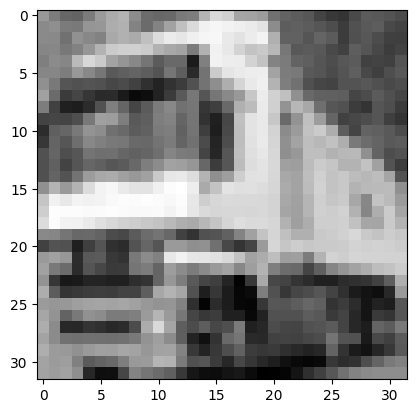

In [55]:
plt.imshow(images[3], cmap='gray', interpolation='none')

In [56]:
#Acurácia do Modelo
def avg_test_accuracy(model, X, y):
    output = model(X).get_plain_text().softmax(0)
    predicted = output.argmax(1)
    labels = y.get_plain_text().argmax(1)
    correct = (predicted == labels).sum().float()
    return float(correct / y.shape[0])

In [57]:
acc= avg_test_accuracy(model, images_enc, labels_enc)
print('> %.3f' %(acc * 100.0))

> 31.720


In [58]:
acc_test= avg_test_accuracy(model, images_test_enc, labels_test_enc)
print('> %.3f' %(acc_test * 100.0))

> 29.300
